In [1]:
# from leecarter import leecarter
import pandas as pd
from tqdm import tqdm
import numpy.matlib

import numpy as np
from matplotlib import pyplot as plt

#from statsmodels.tsa.arima.model import ARIMA

#import warnings
#from statsmodels.tools.sm_exceptions import ConvergenceWarning
#warnings.simplefilter('ignore', ConvergenceWarning)
#warnings.simplefilter('ignore', UserWarning)

In [2]:
Image_width = 10
plt.rc('text', usetex = True) # latex ticks
plt.rc('text.latex')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern'],
})

EXTRA_SMALL = 10
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
filename = 'death_rates2.txt'

mortality = pd.read_csv(filename, delim_whitespace=True)
mortality = mortality[mortality['Age'] != '110+']
mortality['Age'] = mortality['Age'].astype(int)
mortality['Year'] = mortality['Year'].astype(int)
mortality = mortality[mortality['Age'] <= 100]
mortality['Female_l'] = np.log(mortality['Female'].astype(float))
mortality['Male_l'] = np.log(mortality['Male'].astype(float))
mortality['Total_l'] = np.log(mortality['Total'].astype(float))
mortality = mortality[['Year', 'Age', 'Female_l', 'Male_l', 'Total_l']]
mortality

,Year,Age,Female_l,Male_l,Total_l
0,1958,0,-2.723920,-2.480397,-2.591788
1,1958,1,-5.352562,-5.291540,-5.320972
2,1958,2,-6.357324,-6.197751,-6.272237
3,1958,3,-6.732962,-6.527266,-6.622576
4,1958,4,-7.066751,-6.837297,-6.943382
5,1958,5,-7.253066,-6.966444,-7.096497
6,1958,6,-7.420249,-7.070274,-7.226584
7,1958,7,-7.523941,-7.146012,-7.314221
8,1958,8,-7.747085,-7.275925,-7.480456
9,1958,9,-7.883265,-7.311222,-7.552112


In [4]:
column = 'Female_l'

# **Linear regression**

In [5]:
fm = mortality.pivot(index="Age", columns="Year", values=column)
data = fm.values # (101 (age), 62 (years))

total_years = data.shape[1]
trained_from = 30
trained_to = 41
trained_data = data[:,trained_from:trained_to+1]
trained_time = np.arange(trained_from, trained_to + 1)


b1 = ((trained_time[None,:] - trained_time.mean())*(trained_data-trained_data.mean(1)[:,None])).sum(1)/((trained_time - trained_time.mean())**2).sum()
b0 = trained_data.mean(1)-b1*trained_time.mean()

b1 = b1[:, None] 
b0 = b0[:, None]


estimated_time = np.arange(trained_to + 1, total_years + 1)
estimated_data_without_rw = np.exp(b1*estimated_time[None,:] + b0)

adjusted_trend = b1*trained_time[None,:] + b0

# Products

## Term insurance

Let's consider n-year term life insurance. Forecasted present value net single premium is then:

$$ A^{1, f}_{x:n} = \sum_{k=0}^{n-1} v^{k+1}  {}_k  p^0_x  q^k_{x+k},$$

where $q^t_{x+k}$ is forecasted probability in t-th year of dying in one year of person aged $x+k$. Also see that:

$$ {}_k  p^0_x =  p^0_x p^1_{x+1} \cdot ... \cdot p^{k-1}_{x+(k-1)}, $$

where $p^k_x = 1- q^k_x$.

In [16]:
def calculateProbabilities(estimated_data, n):

    Qx = estimated_data # shape (x, year)




    a = np.arange(0, Qx.shape[1])
    b = np.arange(0, Qx.shape[0])
    a = a[None, :]
    b = b[:, None]


    kPx = []
    Qkx = []
    for x in range(0, Qx.shape[0]-n-1):
        Px = []

        indexes = (b - x == a)*(a < n)

        Qkx.append(Qx[indexes].tolist())
        for k in range(0, n-1):
            indexes = (b - x == a)*(a <= k) # bierzemy ukośnie
            p = (1-Qx)[indexes].prod()
            Px.append(p)
        kPx.append(Px)

    kPx = np.array(kPx) # shape (x, k)
    kPx = np.hstack((np.ones((kPx.shape[0],1)), kPx))
    Qkx = np.array(Qkx) # shape (starting x, k)



    #forecasting_horizon = np.arange(0, n)
    #forecasting_horizon = forecasting_horizon[None, :]

    #discounting_factor = v**forecasting_horizon

    return kPx, Qkx #, discounting_factor


(80,)


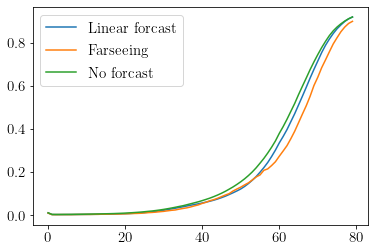

In [20]:
n = 20
delta = 0.01

v = np.exp(-delta)
forecasting_horizon = np.arange(1, n+1)
forecasting_horizon = forecasting_horizon[None, :]

discounting_factor = v**forecasting_horizon


Qx = estimated_data_without_rw # shape (x, year)

kPx, Qkx = calculateProbabilities(Qx, n)

A_linear = discounting_factor*kPx*Qkx
if np.any(kPx > 1): print("error")
if np.any(Qkx > 1): print("error")
A_linear = A_linear.sum(1)

linear = (kPx, Qkx)


# real data
Qx = np.exp(data[:, 42:]) # shape (x, year)

kPx, Qkx = calculateProbabilities(Qx, n)

A_farseer = discounting_factor*kPx*Qkx
if np.any(kPx > 1): print("error")
if np.any(Qkx > 1): print("error")
A_farseer = A_farseer.sum(1)

farseer = (kPx, Qkx)

# without forecasting 
Q = np.exp(data[:, 41])


kPx = []
Qkx = []
for x in range(0, Qx.shape[0]-n-1):
    kPx.append((1-Q[x:x+n-1]).cumprod())
    Qkx.append(Q[x:x+n])
kPx = np.array(kPx)
kPx = np.hstack((np.ones((kPx.shape[0],1)), kPx))
Qkx = np.array(Qkx)
#print(kPx.shape) # (x, k)
#print(discounting_factor.shape)
#print(Qkx.shape)

no_prediction = (kPx, Qkx)

straight_forward_A = (discounting_factor*Qkx*kPx).sum(1)
print(straight_forward_A.shape)
plt.plot(A_linear, label="Linear forcast")
plt.plot(A_farseer, label="Farseeing")
plt.plot(straight_forward_A, label = "No forcast")
plt.legend()
plt.show()

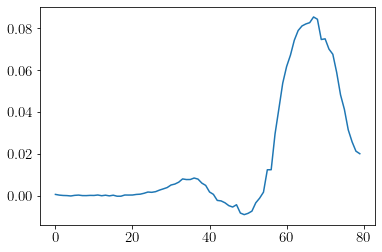

In [18]:
plt.plot(A_linear-A_farseer)
plt.show()

## Life annuity

$$ \overset{..}{a}_{x:n} = \sum_{k=0}^{n-1} v^{k} {}_k p^0_x$$

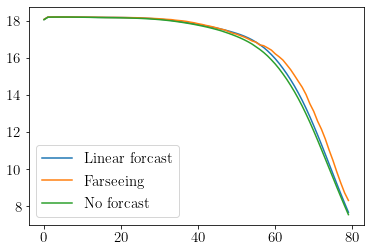

In [26]:
delta = 0.01
v = np.exp(-delta)
forecasting_horizon = np.arange(0, n)
forecasting_horizon = forecasting_horizon[None, :]

discounting_factor = v**forecasting_horizon


kPx, Qkx = linear
a_linear = discounting_factor*kPx
a_linear = a_linear.sum(1)


kPx, Qkx = farseer
a_farseer = discounting_factor*kPx
a_farseer = a_farseer.sum(1)


kPx, Qkx = no_prediction
a_no_prediction = discounting_factor*kPx
a_no_prediction = a_no_prediction.sum(1)


plt.plot(a_linear, label="Linear forcast")
plt.plot(a_farseer, label="Farseeing")
plt.plot(a_no_prediction, label = "No forcast")
plt.legend()
plt.show()

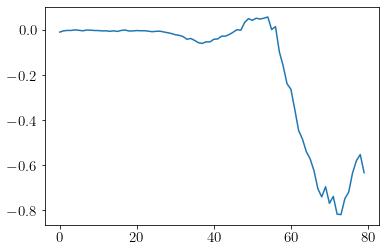

In [27]:
plt.plot(a_linear-a_farseer)
plt.show()